In [1]:
!pip install -q git+https://github.com/Keyza-asyadda/DERMIS-MachineLearning.git

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from tensorflow import keras
import tensorflow as tf

import os
import gc

import dermis_utils

In [3]:
DATA_DIR = '../input/isic-2019-capstone/ISIC_2019'
CACHE_DIR = '/kaggle/tmp/'
IMG_SIZE = 240
EPOCHS = 40
BATCH_SIZE = 32
BRIGHTNESS_LEVEL = .2
NUM_CLASSES = 8
device = 'CPU'

In [4]:
if len(tf.config.list_logical_devices("TPU")) > 0:
    device = "TPU"
elif len(tf.config.list_logical_devices("GPU")) > 0:
    device = "GPU"

In [5]:
os.makedirs(CACHE_DIR)

# Define augmentation func
#### TPU accelerator doesn't support augmentation layer so we need to augment separately based on currently used accelerator

In [6]:
def get_aug_layer():
    model = keras.Sequential([
        keras.layers.RandomBrightness(BRIGHTNESS_LEVEL),
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(.9)
    ], name = "augmentation")
    model.trainable = False
    return model
if device == "TPU":
    AUG_MODEL = None

    def aug_func():
        assert device == "TPU"
        global AUG_MODEL
        if AUG_MODEL is None:
            AUG_MODEL = get_aug_layer()
        def augment(images, labels):
            return aug(images), labels
        return augment

# Import validation data and training data

In [7]:
train_ds = keras.utils.image_dataset_from_directory(
    os.path.join(
        DATA_DIR,
        'train'
    ),
    label_mode = "categorical",
    image_size = (IMG_SIZE, IMG_SIZE),
    shuffle = True,
    batch_size = BATCH_SIZE,
)

class_names = train_ds.class_names

train_ds = train_ds.cache(os.path.join(CACHE_DIR, 'train'))
if device == "TPU":
    train_ds = train_ds.map(aug_func(), num_parallel_calls = tf.data.AUTOTUNE, deterministic = False)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

Found 17731 files belonging to 8 classes.


In [8]:
val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(
        DATA_DIR,
        'val'
    ),
    shuffle = True,
    label_mode = "categorical",
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)
val_ds = val_ds.cache(os.path.join(CACHE_DIR, 'val'))
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Found 3800 files belonging to 8 classes.


# Compute class weight as target variable is heavily imbalanced

In [9]:
num_images = {i:len(os.listdir(os.path.join(DATA_DIR, 'train', i))) for i in class_names}

In [10]:
num_images = list(map(num_images.get, class_names))
num_images

[607, 2326, 1837, 167, 3165, 9012, 440, 177]

In [11]:
num_images = tf.Variable(num_images, dtype='int64', name = "num_images")
num_images

<tf.Variable 'num_images:0' shape=(8,) dtype=int64, numpy=array([ 607, 2326, 1837,  167, 3165, 9012,  440,  177])>

In [12]:
num_images = tf.constant(tf.cast(tf.reduce_sum(num_images) / num_images, tf.float32))
num_images

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 29.210873 ,   7.6229577,   9.65215  , 106.17365  ,   5.6022115,
         1.9674878,  40.297726 , 100.17514  ], dtype=float32)>

In [13]:
weight = {i: num_images[i] for i in range(num_images.shape[0])}

# Define pre-train model as a layer

In [14]:
def get_pre_trained():
    base_model = keras.applications.EfficientNetV2B1(
        include_top = False,
        weights = "imagenet",
        input_shape = (IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False
    return base_model

# Define model

In [15]:
def get_activation_layer(name):
    if name == "swish":
        return dermis_utils.layers.Swish(1)
    elif name == "elu":
        return keras.layers.ELU()
    else:
        return keras.layers.ReLU()

In [16]:
# Define model with on top of pretrain model
def get_model(
    h1_units = 512,
    h1_activation = 'swish',
    h1_dropout_rate = .01,
):
    if device == "TPU":
        # TPU doesn't support augmentation layer
        model = keras.Sequential([
            # Pre-trained model
            get_pre_trained(),

            keras.layers.GlobalAveragePooling2D(),

            keras.layers.BatchNormalization(),
            # New layer
            keras.layers.Dense(h1_units),
            get_activation_layer(h1_activation),
            keras.layers.Dropout(h1_dropout_rate),

            keras.layers.Dense(NUM_CLASSES, activation = 'linear')
        ])
    
    else:
        model = keras.Sequential([
            get_aug_layer(),
            # Pre-trained model
            get_pre_trained(),

            keras.layers.GlobalAveragePooling2D(),

            keras.layers.BatchNormalization(),

            keras.layers.Dense(h1_units),
            get_activation_layer(h1_activation),
            keras.layers.Dropout(h1_dropout_rate),

            keras.layers.Dense(NUM_CLASSES, activation = 'linear')
        ])
    
    return model

In [17]:
if device == "TPU":
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
elif len(tf.config.list_logical_devices("GPU")) > 1:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()

In [18]:
LR = 1e-4
with strategy.scope():
    model = get_model()
    
    model.compile(
    optimizer = keras.optimizers.Adam(LR),
    loss = dermis_utils.losses.CategoricalFocalCrossentropy(gamma = 1, alpha =1, from_logits = True),
    metrics = ['accuracy',
              keras.metrics.AUC(
                  name = "auc",
                  multi_label = True,
                  from_logits = True,
              ),
                keras.metrics.Precision(),
               keras.metrics.Recall()
              ]
    )

28456008/28456008 [==============================] - 0s 0us/step


In [19]:
with strategy.scope():
    # Callbacks
    early_stopper = keras.callbacks.EarlyStopping(patience = 5, mode = 'min', restore_best_weights = True)
    logger = keras.callbacks.CSVLogger('focal_loss_model_metricsmetrics.csv')
    reducelr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
    board = keras.callbacks.TensorBoard(log_dir = "logs/focal_loss_model/", histogram_freq = 1)

In [20]:
model.fit(
    train_ds,
    epochs = EPOCHS,
    callbacks = [early_stopper, logger, reducelr, board],
    validation_data = val_ds
)

Epoch 1/40


2023-06-03 21:28:18.805578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-b1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


555/555 [==============================] - 353s 565ms/step - loss: 0.9648 - accuracy: 0.5749 - auc: 0.7180 - precision: 0.3632 - recall: 0.7741 - val_loss: 0.7887 - val_accuracy: 0.6408 - val_auc: 0.7987 - val_precision: 0.3498 - val_recall: 0.8784 - lr: 1.0000e-04
Epoch 2/40
555/555 [==============================] - 70s 125ms/step - loss: 0.7809 - accuracy: 0.6274 - auc: 0.7963 - precision: 0.3637 - recall: 0.8510 - val_loss: 0.7273 - val_accuracy: 0.6597 - val_auc: 0.8232 - val_precision: 0.3514 - val_recall: 0.8955 - lr: 1.0000e-04
Epoch 3/40
555/555 [==============================] - 73s 132ms/step - loss: 0.7123 - accuracy: 0.6533 - auc: 0.8240 - precision: 0.3663 - recall: 0.8721 - val_loss: 0.7033 - val_accuracy: 0.6674 - val_auc: 0.8356 - val_precision: 0.3495 - val_recall: 0.9047 - lr: 1.0000e-04
Epoch 4/40
555/555 [==============================] - 75s 135ms/step - loss: 0.6757 - accuracy: 0.6614 - auc: 0.8375 - precision: 0.3676 - recall: 0.8803 - val_loss: 0.6639 - val_acc

In [21]:
model.save("focalLossModel")

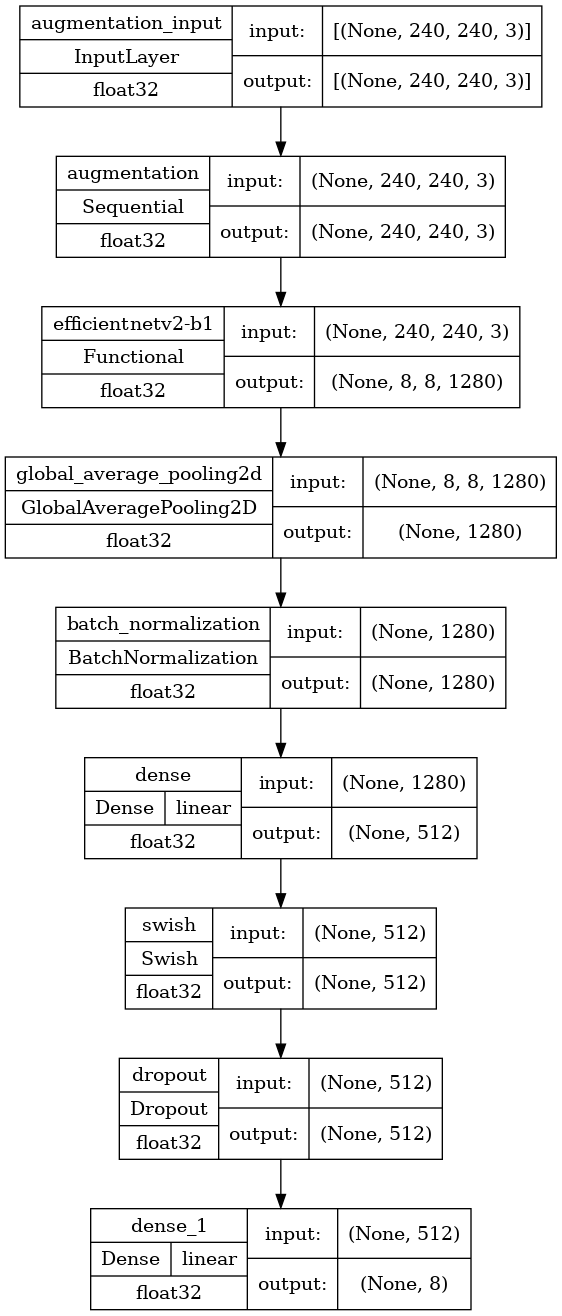

In [22]:
keras.utils.plot_model(
    model,
    show_layer_activations = True,
    show_layer_names = True,
    show_shapes = True,
    show_dtype = True,
    to_file = "focalLossModel.png"
)

# Train similar model with weighted-crossentropy as to compare with previous one

In [23]:
keras.backend.clear_session()
gc.collect()

479968

In [24]:
with strategy.scope():
    model = get_model()
    
    model.compile(
        optimizer = keras.optimizers.Adam(LR),
        loss = keras.losses.CategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy',
                  keras.metrics.AUC(
                      name = "auc",
                      multi_label = True,
                      from_logits = True,
                  ),
                    keras.metrics.Precision(),
                   keras.metrics.Recall()
                  ]
    )

In [25]:
with strategy.scope():
    # Callbacks
    early_stopper = keras.callbacks.EarlyStopping(patience = 5, mode = 'min', restore_best_weights = True)
    logger = keras.callbacks.CSVLogger('weighted_crossentropy_loss.csv')
    reducelr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
    board = keras.callbacks.TensorBoard(log_dir = "logs/weighted_crossentropy_model/", histogram_freq = 1)

In [26]:
model.fit(
    train_ds,
    epochs = EPOCHS,
    callbacks = [early_stopper, logger, reducelr, board],
    validation_data = val_ds,
    class_weight = weight
)

Epoch 1/40


2023-06-03 22:28:12.004200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-b1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


555/555 [==============================] - 108s 145ms/step - loss: 14.1589 - accuracy: 0.3476 - auc: 0.7449 - precision: 0.2244 - recall: 0.6885 - val_loss: 1.4735 - val_accuracy: 0.4453 - val_auc: 0.8128 - val_precision: 0.2608 - val_recall: 0.8034 - lr: 1.0000e-04
Epoch 2/40
555/555 [==============================] - 74s 133ms/step - loss: 11.6359 - accuracy: 0.4558 - auc: 0.8160 - precision: 0.2507 - recall: 0.8147 - val_loss: 1.3087 - val_accuracy: 0.5229 - val_auc: 0.8406 - val_precision: 0.2659 - val_recall: 0.8547 - lr: 1.0000e-04
Epoch 3/40
555/555 [==============================] - 76s 137ms/step - loss: 10.7425 - accuracy: 0.4854 - auc: 0.8342 - precision: 0.2541 - recall: 0.8476 - val_loss: 1.2742 - val_accuracy: 0.5218 - val_auc: 0.8450 - val_precision: 0.2610 - val_recall: 0.8739 - lr: 1.0000e-04
Epoch 4/40
555/555 [==============================] - 84s 151ms/step - loss: 9.8894 - accuracy: 0.5075 - auc: 0.8497 - precision: 0.2560 - recall: 0.8730 - val_loss: 1.2408 - val_

In [27]:
model.save("CrossentropyModel")

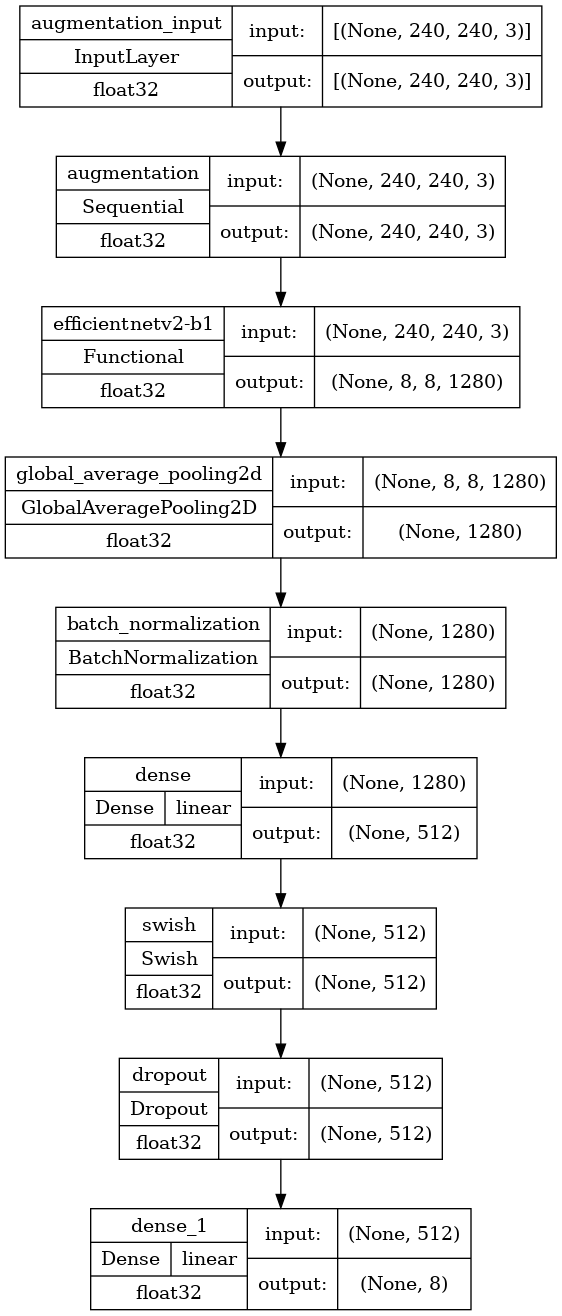

In [28]:
keras.utils.plot_model(
    model,
    show_layer_activations = True,
    show_layer_names = True,
    show_shapes = True,
    show_dtype = True,
    to_file = "crossentropyLossModel.png"
)